# 2. Second Version : 데이터 불균형이 심한 컬럼들 Log 변환
- 인원수(_cnt): 독립변수, 종속변수에 들어갈 컬럼 모두
- 시즌 내, 시즌 간 gap_days
- 연령제한(age_rating)

## 01. import, log 변환 후 분포도

In [1]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings(action='ignore')
from IPython.display import Image

In [2]:
# 데이터 불러오기
df = pd.read_excel('../data/file/ml_all.xlsx', index_col=0)

In [3]:
# 장르 문자열을 분리하여 개별 항목으로 변환
df['genre'] = df['genre'].str.split(', ')

# 각 영화에 대한 모든 고유한 장르를 수집
all_genres = set(genre for sublist in df['genre'] for genre in sublist)

# Multi-Hot Encoding을 수행할 데이터프레임 초기화
for genre in all_genres:
    df[genre] = 0

# 각 영화에 대해 해당하는 장르에 1 할당
for index, row in df.iterrows():
    for genre in row['genre']:
        df.at[index, genre] = 1

# 장르 열을 삭제
df = df.drop(columns=['genre'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 601 entries, 0 to 600
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   korean_title                  601 non-null    object 
 1   english_title                 601 non-null    object 
 2   year                          601 non-null    int64  
 3   total_season_num              601 non-null    int64  
 4   runtime                       601 non-null    int64  
 5   age_rating                    601 non-null    int64  
 6   production_country            601 non-null    object 
 7   PCA                           601 non-null    float64
 8   genre_len                     601 non-null    int64  
 9   production_country_freq_code  601 non-null    int64  
 10  production_country_code       601 non-null    int64  
 11  seson_n                       601 non-null    int64  
 12  i_s1_rate                     601 non-null    float64
 13  i_s1_rate_

In [4]:
# 제작국가 레이블 인코딩한 컬럼으로 대체
df['production_country'] = df['production_country_code']

In [5]:
df.head()

,korean_title,english_title,year,total_season_num,runtime,age_rating,production_country,PCA,genre_len,production_country_freq_code,...,코미디,역사,음악,로맨스,Made in Europe,드라마,스포츠,가족,전쟁,서부
0,스위트 투스: 사슴뿔을 가진 소년,Sweet Tooth,2021,2,52,15,3,2.595940,4,221,...,0,0,0,0,0,1,0,0,0,0
1,스위트홈,Sweet Home,2020,2,60,19,0,0.898617,6,176,...,0,0,0,0,0,1,0,0,0,0
2,굿 닥터,The Good Doctor,2017,6,43,15,3,2.471506,1,221,...,0,0,0,0,0,1,0,0,0,0
3,워킹 데드,The Walking Dead,2010,11,46,19,3,4.999856,5,221,...,0,0,0,0,0,1,0,0,0,0
4,"비르기트: 왕국, 권력, 영광",Borgen - Power & Glory,2022,4,58,15,4,1.375249,3,11,...,0,0,0,0,1,1,0,0,1,0


In [6]:
# 로그 변환 적용 

df['i_s2_rate_cnt'] = np.log1p(df['i_s2_rate_cnt'])  # log(1+x) 변환 사용
df['w_s2_rate_cnt'] = np.log1p(df['w_s2_rate_cnt'])
df['s2_rate_cnt_retention'] = np.log1p(df['s2_rate_cnt_retention'])

df['i_s1_rate_cnt'] = np.log1p(df['i_s1_rate_cnt'])
df['w_s1_rate_cnt'] = np.log1p(df['w_s1_rate_cnt'])
df['s1_rate_cnt_retention'] = np.log1p(df['s1_rate_cnt_retention'])

df['s1_gap_days'] = np.log1p(df['s1_gap_days'])
df['season_gaps_days'] = np.log1p(df['season_gaps_days'])
df['age_rating'] = np.log1p(df['age_rating'])

In [7]:
# 분포도

# 첫 번째 그래프: 6개의 속성 히스토그램
fig1 = make_subplots(rows=2, cols=3, subplot_titles=['imdb_s2 평점', 'imdb_s2 평점 참여 수', 'watcha_s2 평점', 'watcha_s2 평점 참여 수', 's2 평점 유지도', 's2 평점 참여 수 유지도'])
columns1 = ['i_s2_rate', 'i_s2_rate_cnt', 'w_s2_rate', 'w_s2_rate_cnt', 's2_rate_retention', 's2_rate_cnt_retention']

for i, col in enumerate(columns1):
    fig1.add_trace(go.Histogram(x=df[col], name=col), row=(i // 3) + 1, col=(i % 3) + 1)

fig1.update_layout(title_text='y값(다음 시즌의 흥행도를 나타내는 컬럼)', showlegend=False)

# 두 번째 그래프: 8개의 속성 히스토그램
fig2 = make_subplots(rows=2, cols=4, subplot_titles=['런타임', '연령 제한', '제작국가', '시즌 번호', '전반적인 흥행(PCA)', '장르 다양성', '시즌1의 gaps_days', '시즌 간의gaps_days'])
columns2 = ['runtime', 'age_rating', 'production_country', 'seson_n', 'PCA', 'genre_len', 's1_gap_days', 'season_gaps_days']

for i, col in enumerate(columns2):
    fig2.add_trace(go.Histogram(x=df[col], name=col), row=(i // 4) + 1, col=(i % 4) + 1)

fig2.update_layout(title_text='x값_1(드라마의 특징)', showlegend=False)

# 세 번째 그래프: 6개의 속성 히스토그램
fig3 = make_subplots(rows=2, cols=3, subplot_titles=['imdb_s1 평점', 'imdb_s1 평점 참여 수', 'watcha_s1 평점', 'watcha_s1 평점 참여 수', 's1 평점 유지도', 's1 평점 참여 수 유지도'])
columns3 = ['i_s1_rate', 'i_s1_rate_cnt', 'w_s1_rate', 'w_s1_rate_cnt', 's1_rate_retention', 's1_rate_cnt_retention']

for i, col in enumerate(columns3):
    fig3.add_trace(go.Histogram(x=df[col], name=col), row=(i // 3) + 1, col=(i % 3) + 1)

fig3.update_layout(title_text='x값_2(이전 시즌의 흥행도를 나타내는 컬럼)', showlegend=False)

# 그래프 출력
fig1.show()
fig2.show()
fig3.show()

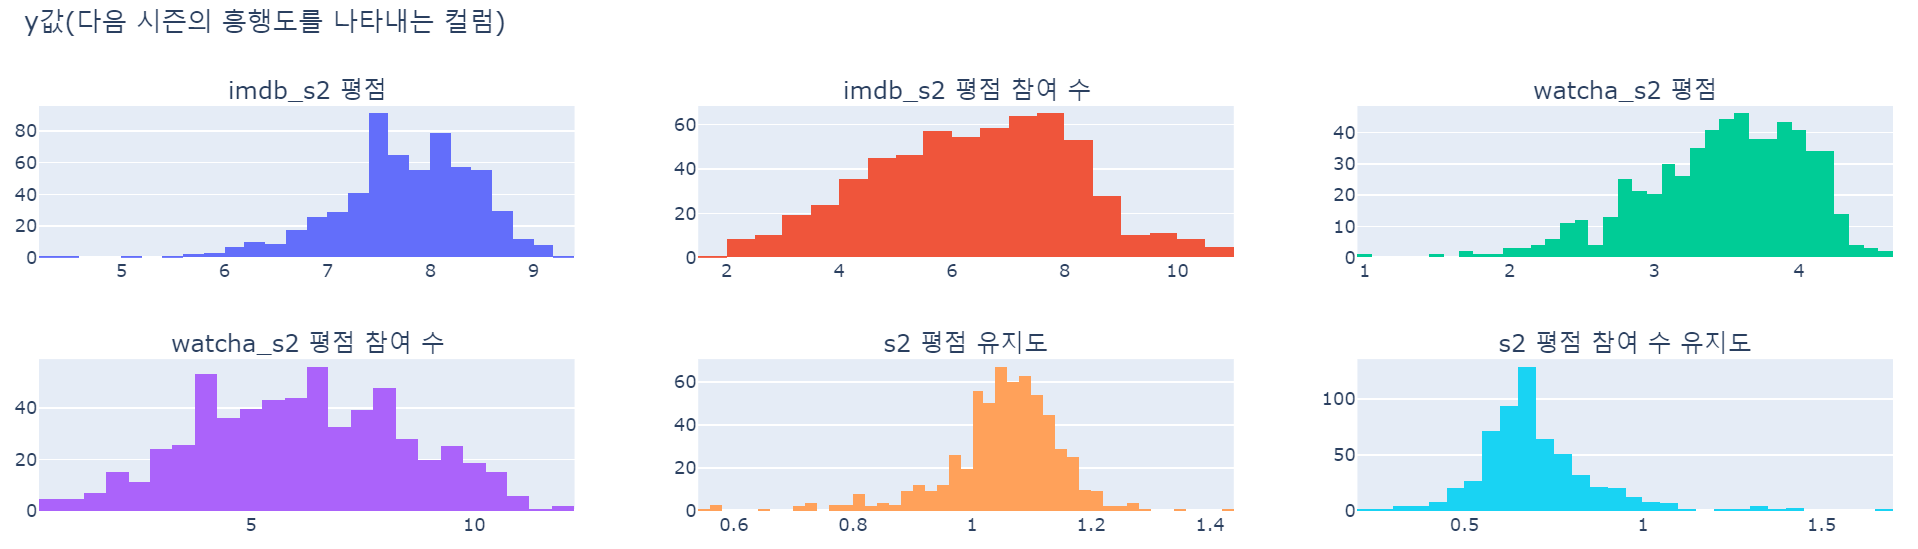

In [8]:
Image(filename='../data/image/v2_1.png') 

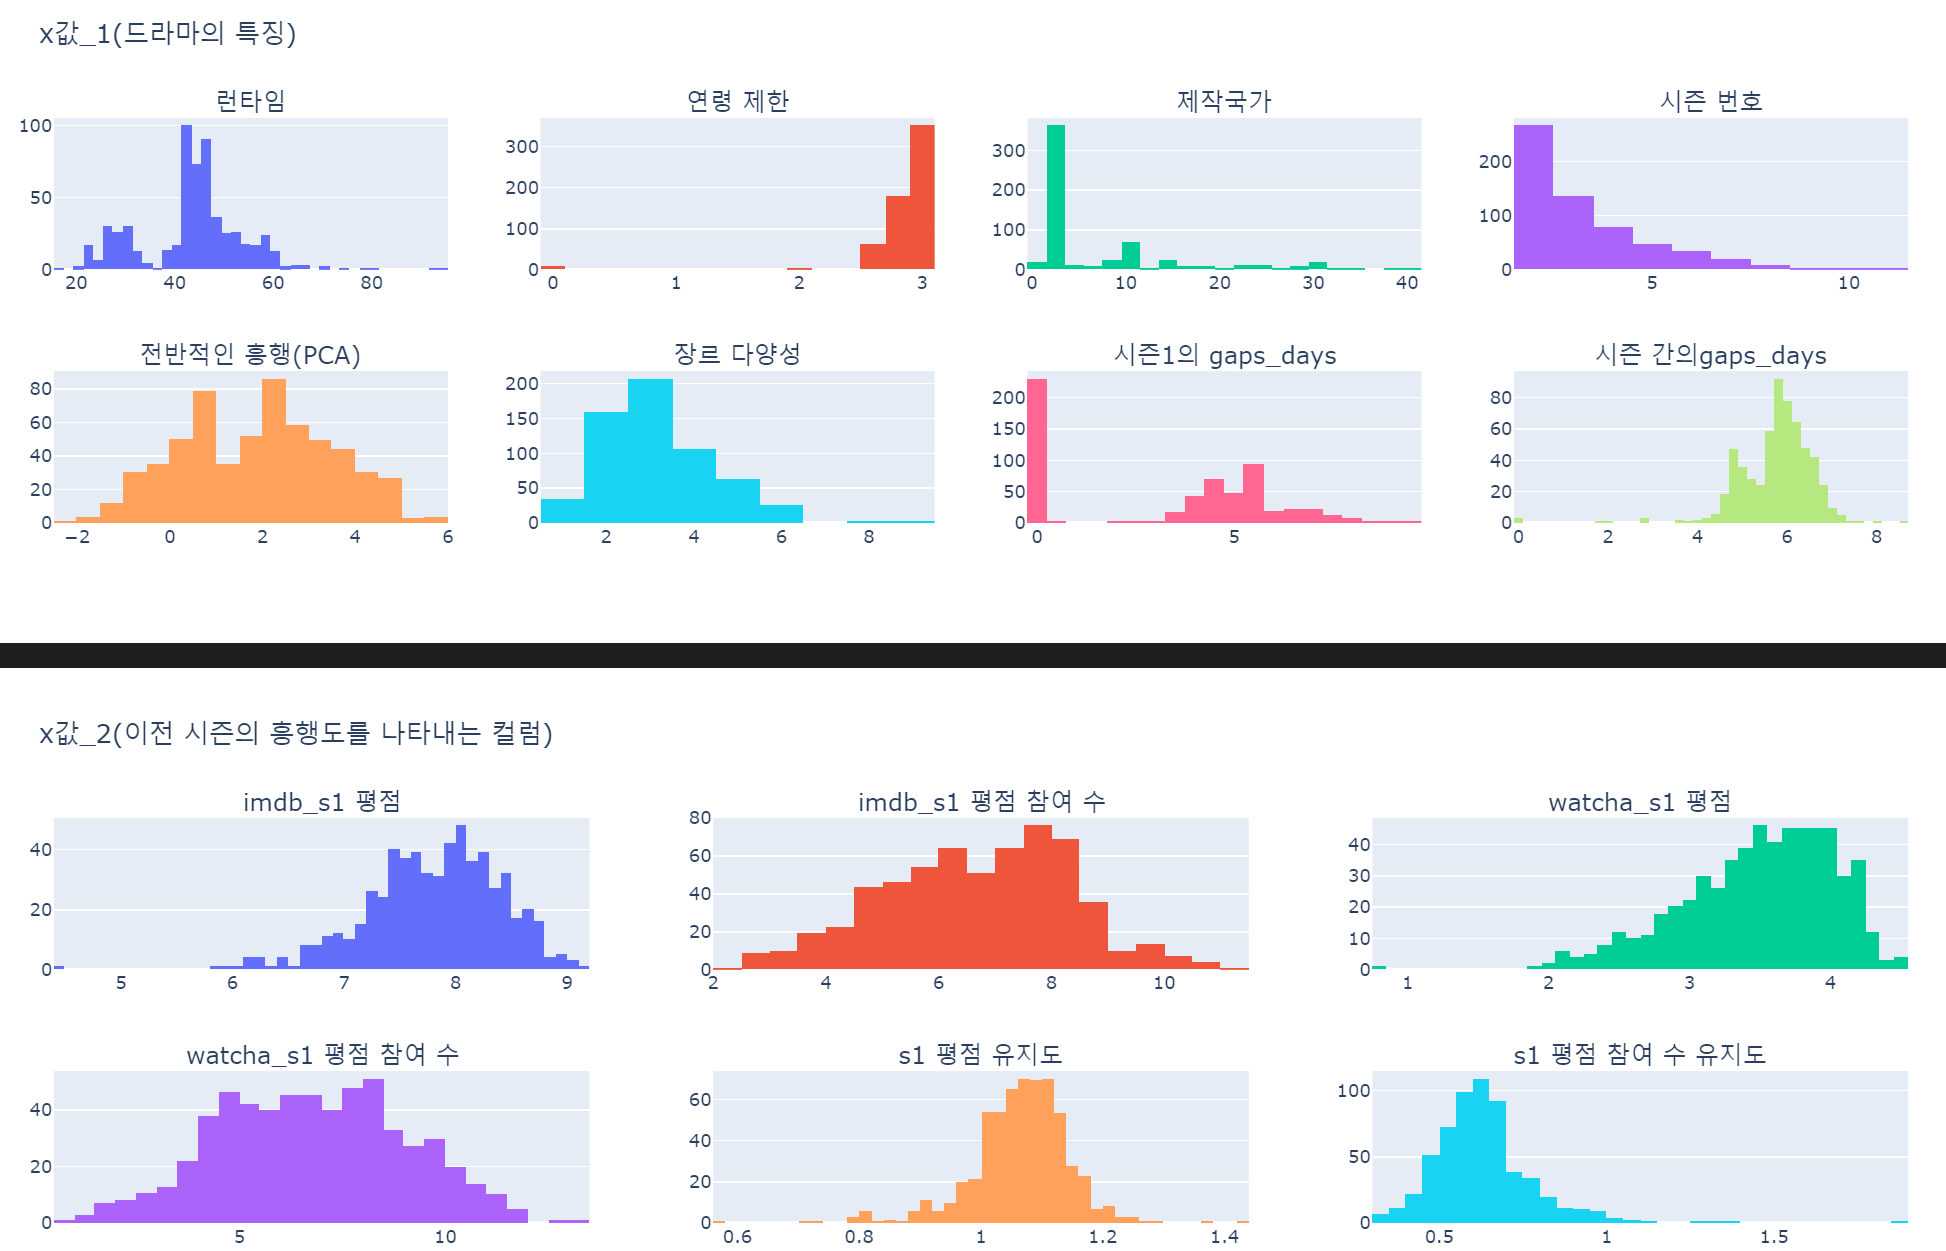

In [9]:
Image(filename='../data/image/v2_2.png') 

## 01-2. y값(다음 시즌 흥행도) 설정과 y값의 그래프

In [10]:
# Score(y값)

# 각 요소 계산
# 점수 부여: 인원 수에만 로그를 취함
rate = (0.8 * df['i_s2_rate']) + (0.2 * df['w_s2_rate'])
cnt = (0.8 * df['i_s2_rate_cnt']) + (0.2 * df['w_s2_rate_cnt'])
ret = (0.4 * df['s2_rate_retention']) + (0.6 * df['s2_rate_cnt_retention'])   

# 총 점수 계산
total = (0.3 * rate + 0.5 * cnt + 0.2 * ret) *10

# 점수를 데이터프레임에 추가
df['score'] = total

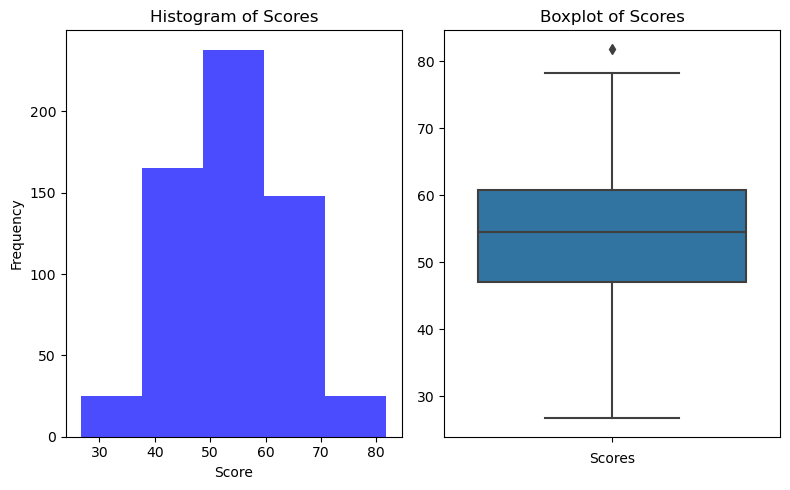

In [11]:
# 서브플롯 생성 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# 첫 번째 서브플롯에 히스토그램
axes[0].hist(df['score'], bins=5, color='blue', alpha=0.7)
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Scores')

# 두 번째 서브플롯에 박스플롯
sns.boxplot(data=df, y="score", ax=axes[1])
axes[1].set_title('Boxplot of Scores')
axes[1].set_xlabel('Scores')
axes[1].set_ylabel('')

# 플롯 보여주기
plt.tight_layout()
plt.show()

- 처음 버전과 달리 분포가 더 균일해짐을 확인

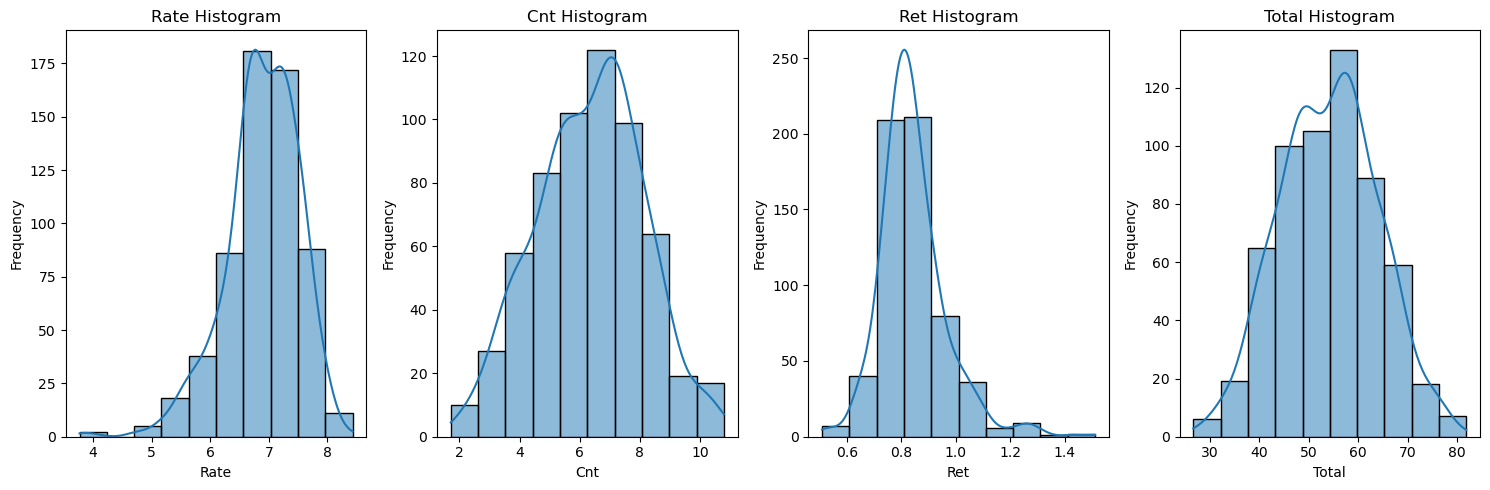

In [12]:
# 히스토그램 그리기
plt.figure(figsize=(15, 5))

# rate 히스토그램
plt.subplot(1, 4, 1)
sns.histplot(rate, bins=10, kde=True)
plt.title('Rate Histogram')
plt.xlabel('Rate')
plt.ylabel('Frequency')

# cnt 히스토그램
plt.subplot(1, 4, 2)
sns.histplot(cnt, bins=10, kde=True)
plt.title('Cnt Histogram')
plt.xlabel('Cnt')
plt.ylabel('Frequency')

# ret 히스토그램
plt.subplot(1, 4, 3)
sns.histplot(ret, bins=10, kde=True)
plt.title('Ret Histogram')
plt.xlabel('Ret')
plt.ylabel('Frequency')

# total 히스토그램
plt.subplot(1, 4, 4)
sns.histplot(total, bins=10, kde=True)
plt.title('Total Histogram')
plt.xlabel('Total')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

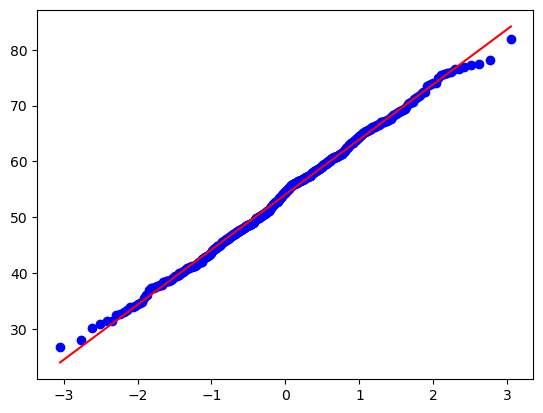

In [13]:
# QQ plot 그리기
stats.probplot(df['score'], dist="norm", plot=plt)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.show()

- log변환 후 다음 시즌 흥행도의 히스토그램과 분포도로,
정규 분포에 가까운 형태의 히스토그램과 QQ-plot으로 정규 분포에 가깝게 분포되어 있음을 확인

In [14]:
df = df[['runtime','age_rating','production_country','PCA','genre_len','seson_n','i_s1_rate','i_s1_rate_cnt','s1_rate_retention','s1_rate_cnt_retention','w_s1_rate','w_s1_rate_cnt','s1_gap_days','season_gaps_days','score',
         'Made in Europe', 'SF', '가족', '공포', '드라마', '로맨스', '범죄', '서부', '스릴러', '스포츠', '액션', '역사', '음악', '전쟁', '코미디' ,'판타지']]

---

## 02-1. Modeling

In [15]:
X = df.drop(['score'], axis=1)  # 'score' 열을 제외한 모든 열 선택
y = df['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [16]:
# DecisionTreeRegressor 모델 초기화
dt_model = DecisionTreeRegressor(random_state=13)
dt_model.fit(X_train, y_train)
predictions = dt_model.predict(X_test)

# 회귀 모델의 성능 평가
dt_mse = mean_squared_error(y_test, predictions)
dt_mae = mean_absolute_error(y_test, predictions)
dt_r2 = r2_score(y_test, predictions)

In [17]:
# RandomForestRegressor 모델 초기화
rf_model = RandomForestRegressor(random_state=13)
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

# 회귀 모델의 성능 평가
rf_mse = mean_squared_error(y_test, predictions)
rf_mae = mean_absolute_error(y_test, predictions)
rf_r2 = r2_score(y_test, predictions)

In [18]:
# KNeighborsRegressor 모델 초기화
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# 회귀 모델의 성능 평가
knn_mse = mean_squared_error(y_test, knn_predictions)
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_r2 = r2_score(y_test, knn_predictions)

Exception in thread Thread-6:
Traceback (most recent call last):
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\subprocess.py", line 1386, in _readerthread
    buffer.append(fh.read())
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\codecs.py", line 322, in decode
    (result, consumed) = self._buffer_decode(data, self.errors, final)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb1 in position 24: invalid start byte
  File "c:\Users\rbfl7\miniconda3\envs\ds_study\lib\site-packages\joblib\externals\loky\backend\context.py", line 202, in _count_physical_cores
    cpu_info = cpu_info.stdout.splitlines()


In [19]:
# XGBRegressor 모델 초기화
xgb_model = XGBRegressor(random_state=13)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# 회귀 모델의 성능 평가
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

In [20]:
# AdaBoostRegressor 모델 초기화
ada_model = AdaBoostRegressor(random_state=13)
ada_model.fit(X_train, y_train)
ada_predictions = ada_model.predict(X_test)

# 회귀 모델의 성능 평가
ada_mse = mean_squared_error(y_test, ada_predictions)
ada_mae = mean_absolute_error(y_test, ada_predictions)
ada_r2 = r2_score(y_test, ada_predictions)

In [ ]:
# LGBMRegressor 모델 초기화
lgb_model = LGBMRegressor(random_state=13)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)

# 회귀 모델의 성능 평가
lgb_mse = mean_squared_error(y_test, lgb_predictions)
lgb_mae = mean_absolute_error(y_test, lgb_predictions)
lgb_r2 = r2_score(y_test, lgb_predictions)

In [22]:
# GradientBoostingRegressor 모델 초기화
gbr_model = GradientBoostingRegressor(random_state=13)
gbr_model.fit(X_train, y_train)
gbr_predictions = gbr_model.predict(X_test)

# 회귀 모델의 성능 평가
gbr_mse = mean_squared_error(y_test, gbr_predictions)
gbr_mae = mean_absolute_error(y_test, gbr_predictions)
gbr_r2 = r2_score(y_test, gbr_predictions)

In [23]:
# LinearRegression 모델 초기화
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# LinearRegression 모델의 성능 평가
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

---

## 02-2. 모델링 결과

In [24]:
model_result = pd.DataFrame({
    'MSE': [dt_mse, rf_mse, knn_mse, xgb_mse, ada_mse, lgb_mse, gbr_mse, lr_mse],
    'MAE': [dt_mae, rf_mae, knn_mae, xgb_mae, ada_mae, lgb_mae, gbr_mae, lr_mae],
    'R2': [dt_r2, rf_r2, knn_r2, xgb_r2, ada_r2, lgb_r2, gbr_r2, lr_r2]
}, index=['DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor', 'XGBoostRegressor', 'AdaBoostRegressor', 'LightGBMRegressor', 'GradientBoostingRegressor', 'LinearRegression'])
print(model_result)

                                 MSE       MAE        R2
DecisionTreeRegressor      11.483657  2.540998  0.867437
RandomForestRegressor       4.466591  1.551073  0.948439
KNeighborsRegressor        17.321634  3.184472  0.800045
XGBoostRegressor            5.585875  1.701188  0.935519
AdaBoostRegressor           6.476082  2.009755  0.925242
LightGBMRegressor           3.909965  1.499383  0.954865
GradientBoostingRegressor   3.481525  1.416129  0.959811
LinearRegression            3.046352  1.366840  0.964834


In [25]:
# prompt: 제일 좋은 성능 두가지
print("MSE 기준")
print(model_result.sort_values(by=['MSE'], ascending=True).head(3))
print(" ")

print("MAE 기준")
print(model_result.sort_values(by=['MAE'], ascending=True).head(3))
print(" ")

print("R2 기준")
print(model_result.sort_values(by=['R2'], ascending=False).head(3))

MSE 기준
                                MSE       MAE        R2
LinearRegression           3.046352  1.366840  0.964834
GradientBoostingRegressor  3.481525  1.416129  0.959811
LightGBMRegressor          3.909965  1.499383  0.954865
 
MAE 기준
                                MSE       MAE        R2
LinearRegression           3.046352  1.366840  0.964834
GradientBoostingRegressor  3.481525  1.416129  0.959811
LightGBMRegressor          3.909965  1.499383  0.954865
 
R2 기준
                                MSE       MAE        R2
LinearRegression           3.046352  1.366840  0.964834
GradientBoostingRegressor  3.481525  1.416129  0.959811
LightGBMRegressor          3.909965  1.499383  0.954865


---